**PCA and ANN Experimentation**

In this notebook, you will find a working implementation of a simple artifical neural network for the purpose of classifying students as a graduate or dropout, based on a variety of factors.

***Data Exploration***

Below, we utilize knowledge from forward-selection, perform PCA, and do some data exploration to visualize our data.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [23]:
data = pd.read_csv("/spring_2024/CS_4262/project/college_dropout/dataset.csv")

In [24]:
data = data.dropna()
processed_data = data[~data["Target"].str.contains("Enroll")].copy()

# Drop columns that are very sparse or have no correlation with the target
processed_data.drop(['International',
           'Nacionality',
           "Mother's qualification",
           "Curricular units 1st sem (evaluations)",
           "Mother's occupation",
           "Father's occupation",
           "Father's qualification",
           'Unemployment rate',
           "Application order",
           "GDP",
           'Inflation rate'],axis=1,inplace=True)

processed_data.loc[:, 'Target_Binary'] = processed_data['Target'].apply(lambda x: 0 if x == "Dropout" else 1) # includes the target binary column
exploration_data = processed_data.drop(columns=["Target", "Target_Binary"]) # includes only the features

In [25]:
print(processed_data)

      Marital status  Application mode  Course  Daytime/evening attendance  \
0                  1                 8       2                           1   
1                  1                 6      11                           1   
2                  1                 1       5                           1   
3                  1                 8      15                           1   
4                  2                12       3                           0   
...              ...               ...     ...                         ...   
4419               1                 1      15                           1   
4420               1                 1      15                           1   
4421               1                 1      12                           1   
4422               1                 1       9                           1   
4423               1                 5      15                           1   

      Previous qualification  Displaced  Educational special ne

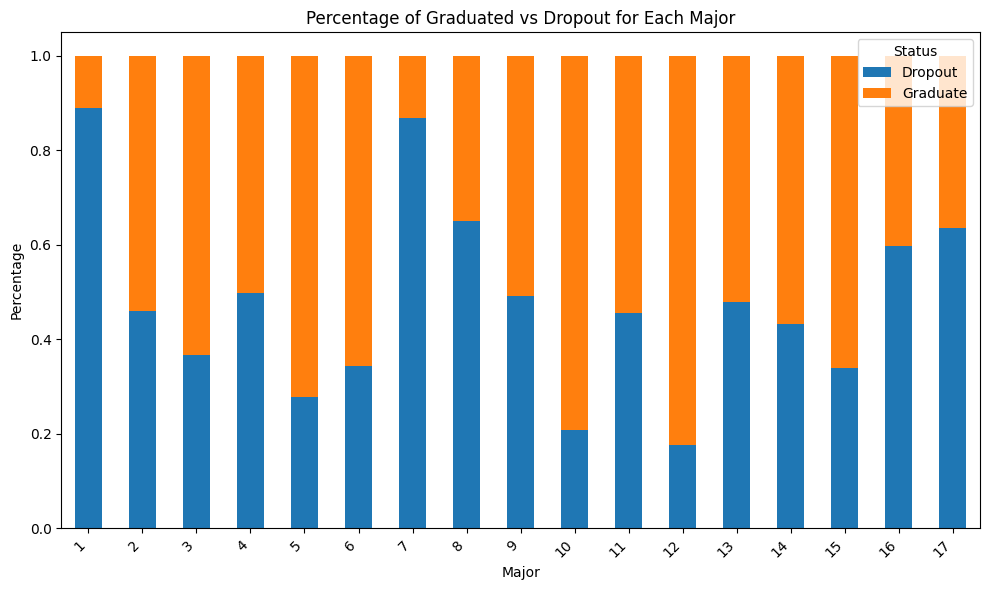

In [26]:
# Group by 'Major' and calculate the percentage of each status
status_percentage = processed_data.groupby('Course')['Target'].value_counts(normalize=True).unstack().fillna(0)

# Plotting
ax = status_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Percentage of Graduated vs Dropout for Each Major')
plt.xlabel('Major')
plt.ylabel('Percentage')
plt.legend(title='Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


***PCA Dimensionality Reduction***

Overall, there are 34 features in this dataset, each represented numerically, whether they are categorical or continuous. Using forward-selection, we removed several features that had a correlation score below 0.15. Below, PCA is performed in order to further reduce the dimensionality of the dataset. This serves as one of the bases of our project, as we are additionally attempting to determine how PCA reduction following forward-selection affects classification results in a mixed continuous/categorical dataset.

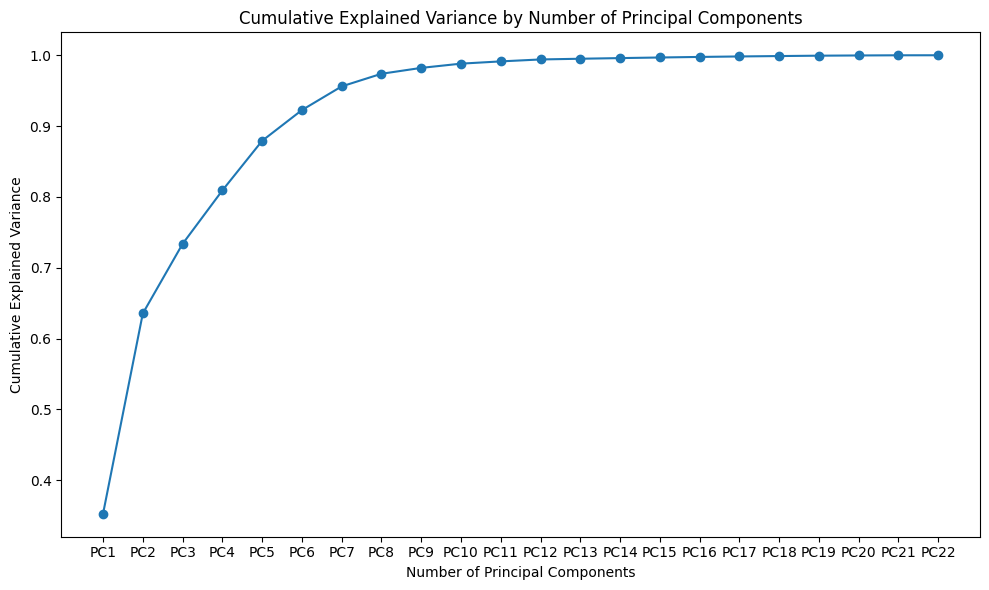

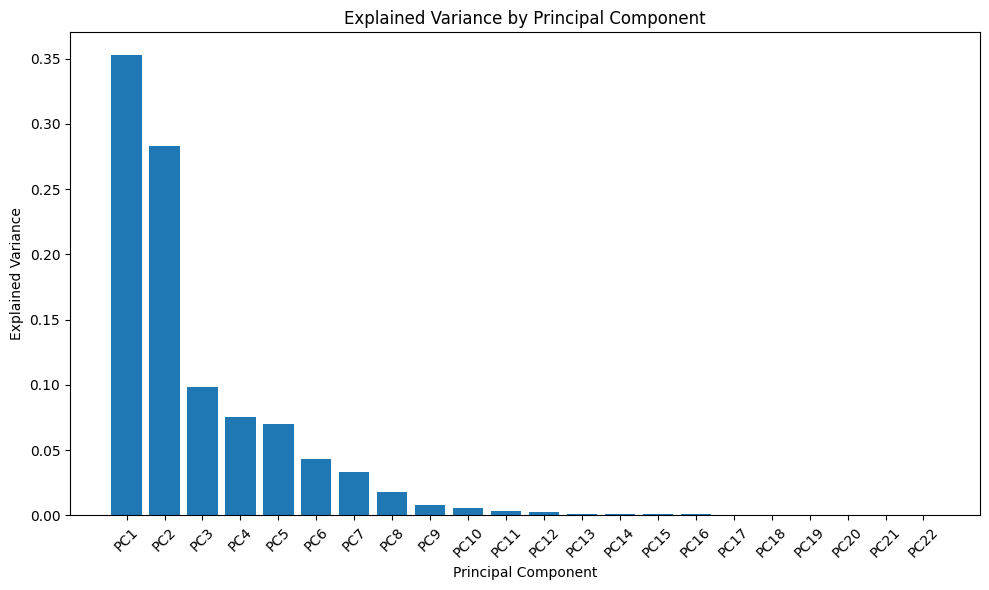

The first 20 principal components explain 99.97% of the variance.
The first 12 principal components explain 99.41% of the variance.


In [27]:
# Perform feature scaling prior to PCA
data = exploration_data.iloc[:, 1:] # Drop index column

# Perform PCA
data_cov = np.cov(data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(data_cov)

# Sort the eigenvectors by decreasing eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigvals = eigenvalues[sorted_indices]
sorted_eigvecs = eigenvectors[:, sorted_indices]

# Calculate the explained variance
explained_variance = sorted_eigvals / np.sum(sorted_eigvals)

# Calculate the cumulative explained variance for each number of components
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(exploration_data.columns), 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(exploration_data.columns))
           , ['PC{}'.format(i) for i in range(1, len(exploration_data.columns))])
plt.tight_layout()
plt.show()

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(exploration_data.columns)), explained_variance)
plt.title('Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(exploration_data.columns))
           , ['PC{}'.format(i) for i in range(1, len(exploration_data.columns))]
           , rotation=45)
plt.tight_layout()
plt.show()

first_20_explained_variance = cumulative_explained_variance[19]
first_12_explained_variance = cumulative_explained_variance[11]
print(f'The first 20 principal components explain {first_20_explained_variance * 100:.2f}% of the variance.')
print(f'The first 12 principal components explain {first_12_explained_variance * 100:.2f}% of the variance.')

In [28]:
# top_20_eigvecs = sorted_eigvecs[:, :10]
top_eigvecs = sorted_eigvecs[:, :12]

# Project the data onto the top 20 eigenvectors
# data_proj = np.dot(data_scaled, top_20_eigvecs)
data_proj = np.dot(data, top_eigvecs)

# Reconstruct the data using the top 20 eigenvectors
# data_reconstructed = np.dot(data_proj, top_20_eigvecs.T)

data_reconstructed = np.dot(data_proj, top_eigvecs.T)


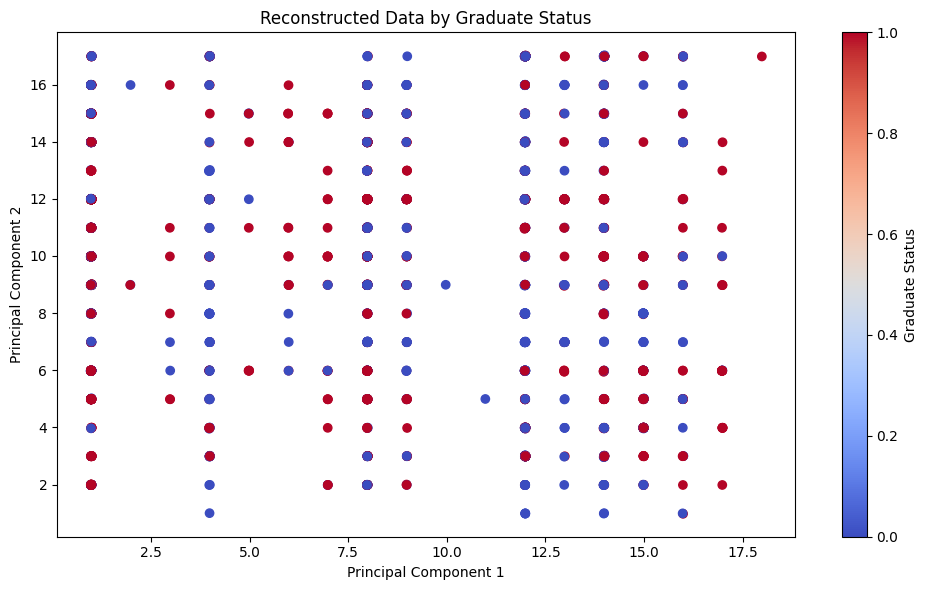

In [29]:
# Plot reconstructed data to see any trends with target variable
plt.figure(figsize=(10, 6))
plt.scatter(data_reconstructed[:, 0], data_reconstructed[:, 1], c=processed_data['Target_Binary'], cmap='coolwarm')
plt.title('Reconstructed Data by Graduate Status')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Graduate Status')
plt.tight_layout()
plt.show()

**Implement ANN to classify Graduate or Dropout**
* Uses Keras to apply hidden layers
* 5-fold cross-validation performed using GridSearchCV to determine the best hyperparameters for this circumstance

In [30]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [31]:
# Custom KerasClassifier wrapper to allow for grid search/cross-validation - for PCA-reduced data
class CustomKerasClassifier(KerasClassifier):
    def __init__(self, activation='relu', dropout_rate=0.5, **kwargs):
        super().__init__(**kwargs)
        self.activation = activation
        self.dropout_rate = dropout_rate

    def _keras_build_fn(self, **kwargs):
        model = Sequential()
        model.add(Dense(64, input_dim=12, activation=self.activation))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(32, activation=self.activation))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=kwargs.get('optimizer', 'adam'), metrics=['accuracy'])
        return model

# Create CustomKerasClassifier wrapper
model_wrapper = CustomKerasClassifier(epochs=10, batch_size=24, verbose=0)

# Define parameter grids
param_grid = {
    'optimizer': ['adam', 'adamw'],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_proj, processed_data['Target_Binary'], test_size=0.2, random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print best parameters and results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

# Evaluate best model
best_model = grid_search.best_estimator_
# Evaluate best model
best_keras_model_reduced = best_model.model_
y_predict_reduced = best_keras_model_reduced.predict(X_test)

c:\Users\15029\anaconda3\envs\learn\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\15029\anaconda3\envs\learn\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\15029\anaconda3\envs\learn\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Best: 0.895311 using {'activation': 'tanh', 'dropout_rate': 0.3, 'optimizer': 'adamw'}
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Confusion Matrix:
[[227  50]
 [ 21 428]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.86       277
           1       0.90      0.95      0.92       449

    accuracy                           0.90       726
   macro avg       0.91      0.89      0.89       726
weighted avg       0.90      0.90      0.90       726

Precision on reduced:  0.895397489539749
Recall on reduced:  0.9532293986636972
F1 on reduced:  0.9234088457389428
Accuracy on reduced:  0.9022038567493113


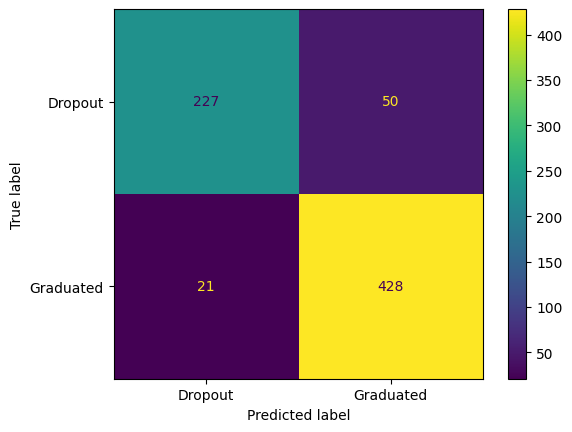

In [32]:
# Report test metrics
y_predict_reduced = np.round(y_predict_reduced)

# Calculate confusion matrix
conf_matrix_reduced = confusion_matrix(y_test, y_predict_reduced)

# Calculate classification report
class_report_reduced = classification_report(y_test, y_predict_reduced)

# Compute precision, recall, and F1 score
precision_reduced = precision_score(y_test, y_predict_reduced)
recall_reduced = recall_score(y_test, y_predict_reduced)
f1_reduced = f1_score(y_test, y_predict_reduced)
accuracy_reduced = accuracy_score(y_test, y_predict_reduced)

print('Confusion Matrix:')
print(conf_matrix_reduced)
print('\nClassification Report:')
print(class_report_reduced)

# Printing metrics for checking classification report
print("Precision on reduced: ", precision_reduced)
print("Recall on reduced: ", recall_reduced)
print("F1 on reduced: ", f1_reduced)
print("Accuracy on reduced: ", accuracy_reduced)

# Plot confusion matrix
confusion_display = ConfusionMatrixDisplay(conf_matrix_reduced, display_labels=['Dropout', 'Graduated'])

confusion_display.plot()

In [33]:
# Custom KerasClassifier wrapper to allow for grid search/cross-validation - for non-PCA-reduced data
class CustomKerasClassifier(KerasClassifier):
    def __init__(self, activation='relu', dropout_rate=0.5, **kwargs):
        super().__init__(**kwargs)
        self.activation = activation
        self.dropout_rate = dropout_rate

    def _keras_build_fn(self, **kwargs):
        model = Sequential()
        model.add(Dense(64, input_dim=exploration_data.shape[1] - 1, activation=self.activation))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(32, activation=self.activation))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=kwargs.get('optimizer', 'adam'), metrics=['accuracy'])
        return model

# Create CustomKerasClassifier wrapper
model_wrapper = CustomKerasClassifier(epochs=10, batch_size=24, verbose=0)

# Define parameter grids
param_grid = {
    'optimizer': ['adam', 'adamw'],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Train and test model with all data instead of dimensionality reduced data
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(exploration_data.iloc[:, 1:], processed_data['Target_Binary'], test_size=0.2, random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=5)
grid_search.fit(X_train_all, y_train_all)

# Print best parameters and results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

# Evaluate best model
best_model = grid_search.best_estimator_
# Evaluate best model
best_keras_model_all = best_model.model_
y_predict_all = best_keras_model_all.predict(X_test_all)

c:\Users\15029\anaconda3\envs\learn\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\15029\anaconda3\envs\learn\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\15029\anaconda3\envs\learn\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Best: 0.904267 using {'activation': 'tanh', 'dropout_rate': 0.3, 'optimizer': 'adamw'}
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Confusion Matrix:
[[231  46]
 [ 20 429]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       277
           1       0.90      0.96      0.93       449

    accuracy                           0.91       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.91      0.91       726

Precision on all:  0.9031578947368422
Recall on all:  0.955456570155902
F1 on all:  0.9285714285714286
Accuracy on all:  0.9090909090909091


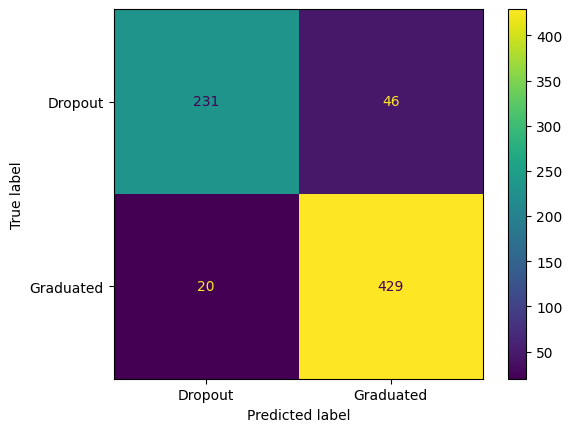

In [34]:
# Print test metrics
# Compute precision, recall, and F1 score
y_predict_all = np.round(y_predict_all)

# Calculate confusion matrix
conf_matrix_all = confusion_matrix(y_test_all, y_predict_all)

# Calculate classification report
class_report_all = classification_report(y_test_all, y_predict_all)


precision_all = precision_score(y_test_all, y_predict_all)
recall_all = recall_score(y_test_all, y_predict_all)
f1_all = f1_score(y_test_all, y_predict_all)
accuracy_all = accuracy_score(y_test_all, y_predict_all)


print('Confusion Matrix:')
print(conf_matrix_all)
print('\nClassification Report:')
print(class_report_all)


# Printing metrics for checking classification report
print("Precision on all: ", precision_all)
print("Recall on all: ", recall_all)
print("F1 on all: ", f1_all)
print("Accuracy on all: ", accuracy_all)


# Plot confusion matrix
confusion_display_all = ConfusionMatrixDisplay(conf_matrix_all, display_labels=['Dropout', 'Graduated'])
confusion_display_all.plot()